## Package imports

In [101]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from textblob import TextBlob

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack
import pickle

In [2]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schellr2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schellr2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schellr2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schellr2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Define functions

In [3]:
def clean_text(df):
    for i in [char for char in ':;"?,/|\\}{1234567890.~!@#$%^&*_+=<>']:
        df.text=df.text.apply(lambda x: str(x).replace(i,""))

    df.text=df.text.apply(lambda x: str(x).replace('-'," "))
    return df

In [4]:
#L = WordNetLemmatizer()
s = SnowballStemmer('english')

def wordPreProcess(sentence):
    return ' '.join([s.stem(x.lower()) for x in re.split('\W', sentence) if len(x) >= 1])

In [5]:
def getTextFeatures(df, txt, max_features=5000, ngrams=(1,2), verbose=True): #, max_features=10000
    if verbose:
        print('processing: ', txt)
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                                 preprocessor=wordPreProcess,
                                 max_features=max_features,
                                 binary=True,
                                 ngram_range=ngrams)
    X = vectorizer.fit_transform(df[txt])
    return X, vectorizer.get_feature_names()

## Import data

In [6]:
data = pd.read_csv('./input/consumer_complaints.csv', header=0)
data.head(10)

C:\Users\schellr2\AppData\Local\Temp\ipykernel_46740\2671578700.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./input/consumer_complaints.csv', header=0)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
5,08/30/2013,Credit card,NaN,Application processing delay,NaN,NaN,NaN,Capital One,NY,12206,NaN,NaN,Phone,09/03/2013,Closed with explanation,Yes,Yes,510098
6,08/30/2013,Credit card,NaN,Credit line increase/decrease,NaN,NaN,NaN,Wells Fargo & Company,AZ,85730,NaN,NaN,Postal mail,09/05/2013,Closed with explanation,Yes,No,511062
7,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,IL,60660,NaN,NaN,Referral,09/04/2013,Closed with explanation,Yes,No,511116
8,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,GA,30016,NaN,NaN,Referral,09/04/2013,Closed with explanation,Yes,No,511091
9,09/17/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",NaN,NaN,NaN,"SunTrust Banks, Inc.",CA,94551,NaN,NaN,Web,09/18/2013,Closed with explanation,Yes,Yes,530602


In [7]:
# save data to df so won't have to reload data if need to start over with df.
df = data.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [9]:
# Only keep records with a complaint narrative
df = df[~df['consumer_complaint_narrative'].isnull()]

In [10]:
# Only keep complaint narrative & product columns to see how well diff methods predict product from just text
df = df[['consumer_complaint_narrative', 'product']]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   consumer_complaint_narrative  66806 non-null  object
 1   product                       66806 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [12]:
df.shape

(66806, 2)

In [13]:
list(df.columns)

['consumer_complaint_narrative', 'product']

In [14]:
product = df['product'].value_counts()
print(product)

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


c:\Users\schellr2\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


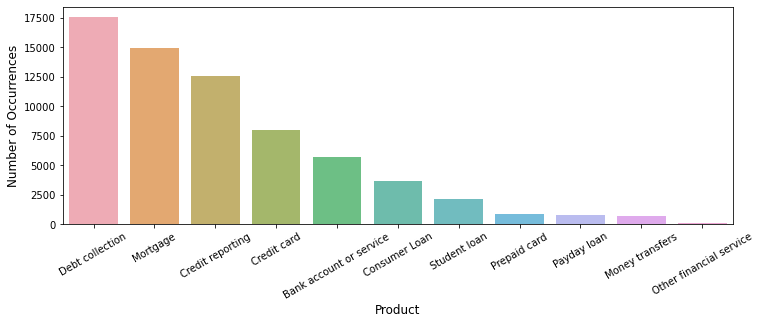

In [15]:
plt.figure(figsize=(12,4))
sns.barplot(product.index, product.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [16]:
for i in df['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! 
They continue to insist I owe them and collection agencies are after me. 
How can I stop this harassment for a bill I already paid four years ago? 

#####################
Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining

In [17]:
df = df.rename({'consumer_complaint_narrative':'text', 'product':'label'},axis=1)

In [18]:
df['text'] = df['text'].astype(str)

In [19]:
df.head()

,text,label
190126,XXXX has claimed I owe them {$27.00} for XXXX ...,Debt collection
190135,Due to inconsistencies in the amount owed that...,Consumer Loan
190155,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
190207,I have an open and current mortgage with Chase...,Mortgage
190208,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage


## Sanitize and vectorize text

In [20]:
df = clean_text(df)

In [22]:
X_text, feat_text = getTextFeatures(df, 'text')

processing:  text


c:\Users\schellr2\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
print(X_text)

  (0, 4971)	0.16561904809480174
  (0, 1754)	0.26636888787163054
  (0, 203)	0.22365830584947977
  (0, 3958)	0.2619335812486446
  (0, 894)	0.14766461202505765
  (0, 717)	0.2606784861169404
  (0, 3006)	0.23642049527306408
  (0, 3186)	0.2476183440143874
  (0, 4927)	0.15260029231073144
  (0, 2871)	0.1853503057215472
  (0, 860)	0.22115749727707837
  (0, 4636)	0.2108612506766266
  (0, 179)	0.13975713778412782
  (0, 1753)	0.21647967772925253
  (0, 2879)	0.09908123962976813
  (0, 202)	0.1405638338092625
  (0, 569)	0.11730573254807165
  (0, 1903)	0.15482017344254168
  (0, 3955)	0.1349832894429062
  (0, 172)	0.11841887712565843
  (0, 891)	0.09891690865826656
  (0, 2110)	0.20079812332469088
  (0, 1024)	0.11590478672554481
  (0, 2148)	0.22912396180812358
  (0, 826)	0.10935226522853173
  :	:
  (66805, 3164)	0.04839373956643697
  (66805, 4924)	0.02396194138933754
  (66805, 3538)	0.048249824055887174
  (66805, 2410)	0.04573509575777334
  (66805, 3273)	0.06673490202603373
  (66805, 3031)	0.058708881898

In [24]:
print(feat_text)

['abid', 'abil', 'abl', 'abl access', 'abl get', 'abl make', 'abl pay', 'abl provid', 'abov', 'absolut', 'absurd', 'abus', 'accept', 'accept payment', 'accept xxxx', 'access', 'access account', 'access credit', 'access fund', 'access money', 'accid', 'accord', 'accord xxxx', 'account', 'account account', 'account activ', 'account also', 'account amount', 'account ani', 'account ask', 'account balanc', 'account bank', 'account becaus', 'account belong', 'account call', 'account charg', 'account chase', 'account check', 'account close', 'account collect', 'account compani', 'account contact', 'account could', 'account credit', 'account current', 'account date', 'account day', 'account delet', 'account delinqu', 'account disput', 'account doe', 'account due', 'account end', 'account even', 'account full', 'account go', 'account good', 'account holder', 'account howev', 'account immedi', 'account includ', 'account inform', 'account list', 'account made', 'account make', 'account manag', 'a

In [25]:
#Saving the combined features into an NPZ file
sparse.save_npz("./bin/tfidf/X_text.npz", X_text)

## Stratified shuffle split data into training and test datasets

In [26]:
df['target'] = df['label'].astype('category').cat.codes  ## better way to factorize problem code to cat IDs

In [27]:
y = df['target'].values
print(X_text.shape)
print(y.shape)

(66806, 5000)
(66806,)


In [28]:
df['target'].value_counts()

4     17552
6     14919
3     12526
2      7929
0      5711
1      3678
10     2128
9       861
8       726
5       666
7       110
Name: target, dtype: int64

In [29]:
# Use stratified shuffle split to keep same class proportions in train and test data.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=2022)

In [30]:
for train_index, test_index in sss.split(X_text, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_text[train_index], X_text[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [21552 17614 26675 ... 21287 55579 26041] TEST: [38106 56208   152 ... 62311   397 32064]
TRAIN: [31334 33221 32682 ... 43019 57821  1023] TEST: [45340 25255 49937 ...  9552 47021 23457]


In [31]:
# Baseline label classifier with logistic regression - minimal params

log_base = LogisticRegression(
    max_iter=10000,
    random_state=2022
)

log_base.fit(X_train, y_train)

y_pred = log_base.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing f1 score %s' % f1_score(y_test, y_pred, average='weighted'))
cm_log_base = confusion_matrix(y_test, y_pred) # can use to make heatmap
cr_log_base = pd.DataFrame(classification_report(y_test, y_pred, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_log_base

Testing accuracy 0.8466546924113156
Testing f1 score 0.8421756973639463


,precision,recall,f1-score,support
0,0.794783,0.800350,0.797557,1142.000000
1,0.767007,0.612772,0.681269,736.000000
2,0.811344,0.829760,0.820449,1586.000000
3,0.852309,0.854691,0.853498,2505.000000
4,0.821943,0.894047,0.856480,3511.000000
5,0.766234,0.443609,0.561905,133.000000
6,0.926230,0.946716,0.936361,2984.000000
7,1.000000,0.000000,0.000000,22.000000
8,0.693878,0.234483,0.350515,145.000000
9,0.818182,0.680233,0.742857,172.000000


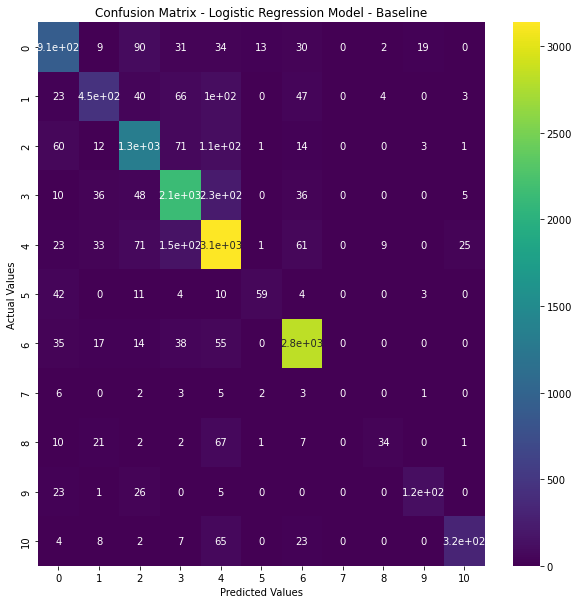

In [32]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log_base, annot=True, cmap='viridis') # cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Logistic Regression Model - Baseline')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Baseline logistic regression performs well with accuracy and f1 score ~84%

# Try hyperparameter optimization for the logistic regression model

In [33]:
# Optimize logistic regression classifier with optuna
def log_objective(trial):
    #penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", "none"]) #use defaut l2 penalty
    tol = trial.suggest_float("tol", 0.0001, 0.0091, step=0.001, log=False)
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    #fit_intercept = trial.suggest_categorical("fit_intercept", ["True", "False"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "sag", "saga"]) #"liblinear", 
    n_jobs = trial.suggest_int("n_jobs", 1, 12, step=1, log=False)
    #l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0, step=0.1, log=False) ## only used by elasticnet
        
    ## Create Model
    log = LogisticRegression(tol=tol, C=C, class_weight=class_weight, solver=solver, n_jobs=n_jobs,
                            max_iter=10000, multi_class = "multinomial", random_state = 2022) #fit_intercept=fit_intercept, l1_ratio=l1_ratio, warm_start=True
    ## Fit Model
    log.fit(X_train, y_train)

    return accuracy_score(y_test, log.predict(X_test))

In [34]:
log_study = optuna.create_study(study_name="Logistic Regression Classifier", direction="maximize")
log_study.optimize(log_objective, n_trials=10)

[I 2022-11-28 11:44:40,982] A new study created in memory with name: Logistic Regression Classifier
[I 2022-11-28 11:44:53,880] Trial 0 finished with value: 0.8451579104924413 and parameters: {'tol': 0.0011, 'C': 0.8, 'class_weight': None, 'solver': 'newton-cg', 'n_jobs': 7}. Best is trial 0 with value: 0.8451579104924413.
[I 2022-11-28 11:45:06,661] Trial 1 finished with value: 0.846579853315372 and parameters: {'tol': 0.0021, 'C': 1.0, 'class_weight': None, 'solver': 'newton-cg', 'n_jobs': 4}. Best is trial 1 with value: 0.846579853315372.
[I 2022-11-28 11:45:15,534] Trial 2 finished with value: 0.8285436311929352 and parameters: {'tol': 0.0041, 'C': 0.9, 'class_weight': 'balanced', 'solver': 'newton-cg', 'n_jobs': 1}. Best is trial 1 with value: 0.846579853315372.
c:\Users\schellr2\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2022-11-28 12:09:40,565] Trial 3 finis

In [35]:
print("Best Params: {}".format(log_study.best_params))
print("\nBest Accuracy: {}".format(log_study.best_value))

Best Params: {'tol': 0.0021, 'C': 1.0, 'class_weight': None, 'solver': 'newton-cg', 'n_jobs': 4}

Best Accuracy: 0.846579853315372


In [36]:
log_clf = LogisticRegression(**log_study.best_params)
log_clf.fit(X_train, y_train)

y_pred_train = log_clf.predict(X_train)
y_pred_test = log_clf.predict(X_test)

log_train_acc = accuracy_score(y_train, y_pred_train)
log_test_acc = accuracy_score(y_test, y_pred_test)

log_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
log_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Logistic Regression Accuracy on Train Dataset: {}".format(log_train_acc))
print("\nLogistic Regression Accuracy on Test Dataset: {}".format(log_test_acc))
print("#####################")
print("\nLogistic Regression F1 Score on Train Dataset: {}".format(log_train_f1))
print("\nLogistic Regression F1 Score on Test Dataset: {}".format(log_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_log = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_log = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_log

Logistic Regression Accuracy on Train Dataset: 0.8850198338447721

Logistic Regression Accuracy on Test Dataset: 0.846579853315372
#####################

Logistic Regression F1 Score on Train Dataset: 0.8821859457433873

Logistic Regression F1 Score on Test Dataset: 0.8421025002556072


,precision,recall,f1-score,support
0,0.794783,0.800350,0.797557,1142.00000
1,0.767007,0.612772,0.681269,736.00000
2,0.810844,0.829760,0.820193,1586.00000
3,0.852250,0.854291,0.853270,2505.00000
4,0.821943,0.894047,0.856480,3511.00000
5,0.766234,0.443609,0.561905,133.00000
6,0.926230,0.946716,0.936361,2984.00000
7,1.000000,0.000000,0.000000,22.00000
8,0.693878,0.234483,0.350515,145.00000
9,0.818182,0.680233,0.742857,172.00000


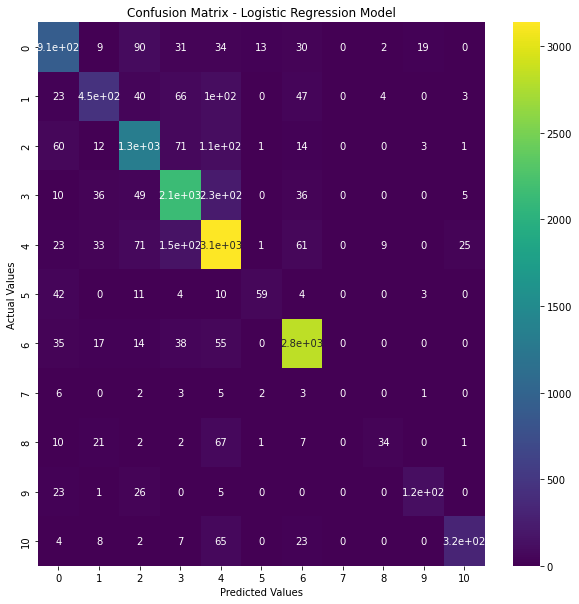

In [37]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Logistic Regression Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Hyperparameter optimization with Optuna did not exhibit much improvement for logistic regression classification accuracy and f1 score.
- ### Slight evidence of overfitting with higher metrics on training data.

# Try other classification model types with hyperparameter optimization

## Passive Aggressive Classifier

In [39]:
# Optimize passive aggressive classifier with optuna
def pac_objective(trial):
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    tol = trial.suggest_float("tol", 0.001, 0.01, step=0.001, log=False)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    n_jobs = trial.suggest_int("n_jobs", 1, 12, step=1, log=False)
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
            
    ## Create Model
    pac = PassiveAggressiveClassifier(C=C, tol=tol, loss=loss, n_jobs=n_jobs, 
                class_weight=class_weight, max_iter=10000, random_state = 2022) 

    ## Fit Model
    pac.fit(X_train, y_train)

    return accuracy_score(y_test, pac.predict(X_test))

In [40]:
pac_study = optuna.create_study(study_name="Passive Aggressive Classifier", direction="maximize")
pac_study.optimize(pac_objective, n_trials=10)

[I 2022-11-28 12:38:28,304] A new study created in memory with name: Passive Aggressive Classifier
[I 2022-11-28 12:38:28,713] Trial 0 finished with value: 0.8479269570423589 and parameters: {'C': 0.2, 'tol': 0.007, 'loss': 'hinge', 'n_jobs': 12, 'class_weight': None}. Best is trial 0 with value: 0.8479269570423589.
[I 2022-11-28 12:38:29,779] Trial 1 finished with value: 0.806615776081425 and parameters: {'C': 0.7000000000000001, 'tol': 0.001, 'loss': 'hinge', 'n_jobs': 7, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8479269570423589.
[I 2022-11-28 12:38:30,536] Trial 2 finished with value: 0.807663523424637 and parameters: {'C': 0.8, 'tol': 0.003, 'loss': 'squared_hinge', 'n_jobs': 4, 'class_weight': None}. Best is trial 0 with value: 0.8479269570423589.
[I 2022-11-28 12:38:31,048] Trial 3 finished with value: 0.8259991019308487 and parameters: {'C': 0.5, 'tol': 0.004, 'loss': 'hinge', 'n_jobs': 10, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.847926957042

In [41]:
print("Best Params: {}".format(pac_study.best_params))
print("\nBest Accuracy: {}".format(pac_study.best_value))

Best Params: {'C': 0.2, 'tol': 0.007, 'loss': 'hinge', 'n_jobs': 12, 'class_weight': None}

Best Accuracy: 0.8479269570423589


In [42]:
pac_clf = PassiveAggressiveClassifier(**pac_study.best_params)
pac_clf.fit(X_train, y_train)

y_pred_train = pac_clf.predict(X_train)
y_pred_test = pac_clf.predict(X_test)

pac_train_acc = accuracy_score(y_train, y_pred_train)
pac_test_acc = accuracy_score(y_test, y_pred_test)

pac_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
pac_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Passive Aggressive Classifier Accuracy on Train Dataset: {}".format(pac_train_acc))
print("\nPassive Aggressive Classifier Accuracy on Test Dataset: {}".format(pac_test_acc))
print("#####################")
print("\nPassive Aggressive Classifier F1 Score on Train Dataset: {}".format(pac_train_f1))
print("\nPassive Aggressive Classifier F1 Score on Test Dataset: {}".format(pac_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_pac = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_pac = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_pac

Passive Aggressive Classifier Accuracy on Train Dataset: 0.9153880697552579

Passive Aggressive Classifier Accuracy on Test Dataset: 0.8487501870977399
#####################

Passive Aggressive Classifier F1 Score on Train Dataset: 0.9146411494019296

Passive Aggressive Classifier F1 Score on Test Dataset: 0.8465006307280486


,precision,recall,f1-score,support
0,0.792287,0.791594,0.791940,1142.00000
1,0.749601,0.638587,0.689655,736.00000
2,0.800983,0.822194,0.811450,1586.00000
3,0.865362,0.864671,0.865016,2505.00000
4,0.839956,0.872971,0.856145,3511.00000
5,0.689076,0.616541,0.650794,133.00000
6,0.929300,0.947051,0.938091,2984.00000
7,0.000000,0.000000,0.000000,22.00000
8,0.612500,0.337931,0.435556,145.00000
9,0.765363,0.796512,0.780627,172.00000


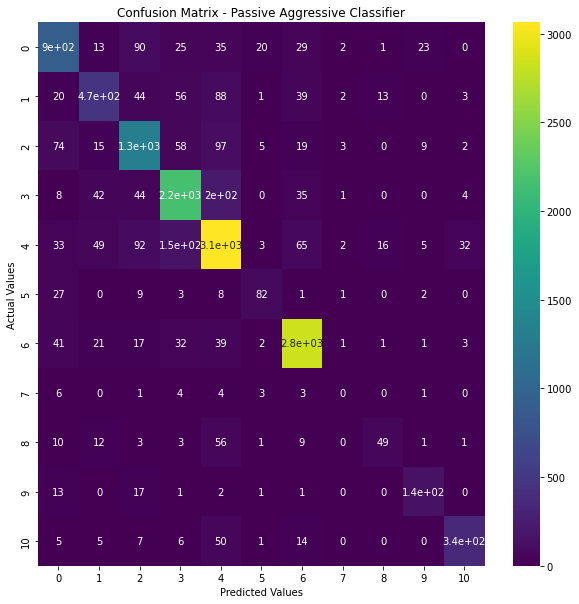

In [43]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_pac, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Passive Aggressive Classifier exhibited similar accuracy and f1 score as Logistic Regression Classifier.
- ### Marginal evidence of overfitting with higher metrics on training data.

## Random Forest Classifier

In [44]:
# Optimize Random Forest Classifier with optuna
def rfc_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 550, step=100, log=False)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int("max_depth", 2, 10, step=2, log=False)
    min_samples_split = trial.suggest_int("min_samples_split", 20, 100, step=20, log=False)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 50, step=10, log=False)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    n_jobs = trial.suggest_int("n_jobs", 1, 12, step=1, log=False)
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
            
    ## Create Model
    rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, 
                                    min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, n_jobs=n_jobs, 
                                    class_weight=class_weight, random_state = 2022) 

    ## Fit Model
    rfc.fit(X_train, y_train)

    return accuracy_score(y_test, rfc.predict(X_test))

In [45]:
rfc_study = optuna.create_study(study_name="Random Forest Classifier", direction="maximize")
rfc_study.optimize(rfc_objective, n_trials=10)

[I 2022-11-28 12:38:35,753] A new study created in memory with name: Random Forest Classifier
[I 2022-11-28 12:38:37,422] Trial 0 finished with value: 0.7572219727585691 and parameters: {'n_estimators': 250, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 60, 'min_samples_leaf': 30, 'max_features': 'log2', 'bootstrap': False, 'n_jobs': 12, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7572219727585691.
[I 2022-11-28 12:38:39,908] Trial 1 finished with value: 0.7566980990869631 and parameters: {'n_estimators': 350, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 50, 'max_features': 'log2', 'bootstrap': True, 'n_jobs': 6, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7572219727585691.
[I 2022-11-28 12:38:41,058] Trial 2 finished with value: 0.7161353090854663 and parameters: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'boots

In [46]:
print("Best Params: {}".format(rfc_study.best_params))
print("\nBest Accuracy: {}".format(rfc_study.best_value))

Best Params: {'n_estimators': 250, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 60, 'min_samples_leaf': 30, 'max_features': 'log2', 'bootstrap': False, 'n_jobs': 12, 'class_weight': 'balanced'}

Best Accuracy: 0.7572219727585691


In [47]:
rfc_clf = RandomForestClassifier(**rfc_study.best_params)
rfc_clf.fit(X_train, y_train)

y_pred_train = rfc_clf.predict(X_train)
y_pred_test = rfc_clf.predict(X_test)

rfc_train_acc = accuracy_score(y_train, y_pred_train)
rfc_test_acc = accuracy_score(y_test, y_pred_test)

rfc_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
rfc_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Random Forest Classifier Accuracy on Train Dataset: {}".format(rfc_train_acc))
print("\nRandom Forest Classifier Accuracy on Test Dataset: {}".format(rfc_test_acc))
print("#####################")
print("\nRandom Forest Classifier F1 Score on Train Dataset: {}".format(rfc_train_f1))
print("\nRandom Forest Classifier F1 Score on Test Dataset: {}".format(rfc_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_rfc = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_rfc = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_rfc

Random Forest Classifier Accuracy on Train Dataset: 0.7618441733403188

Random Forest Classifier Accuracy on Test Dataset: 0.7516838796587337
#####################

Random Forest Classifier F1 Score on Train Dataset: 0.7690630942041441

Random Forest Classifier F1 Score on Test Dataset: 0.7608551871987782


,precision,recall,f1-score,support
0,0.791485,0.634851,0.704568,1142.000000
1,0.704626,0.538043,0.610169,736.000000
2,0.806056,0.621059,0.701567,1586.000000
3,0.679800,0.867864,0.762406,2505.000000
4,0.871130,0.689262,0.769598,3511.000000
5,0.348765,0.849624,0.494530,133.000000
6,0.925808,0.873995,0.899155,2984.000000
7,0.085714,0.272727,0.130435,22.000000
8,0.221130,0.620690,0.326087,145.000000
9,0.347253,0.918605,0.503987,172.000000


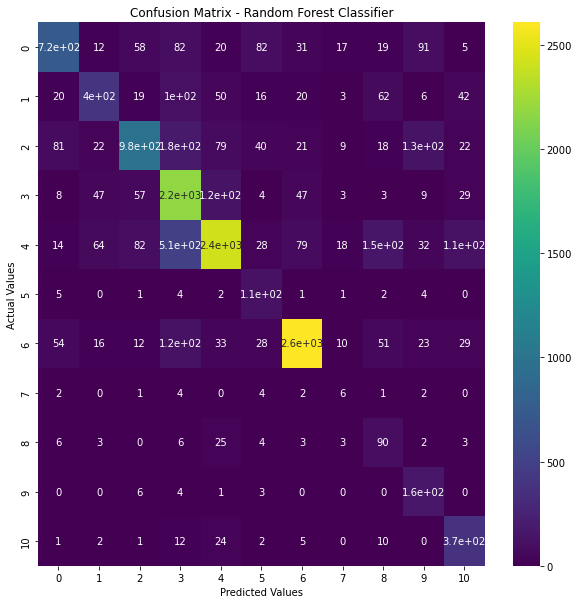

In [48]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Random Forest Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Random Forest Classifier performed slightly worse than Passive Aggressive and Logistic Regression Classifiers.
- ### No evidence of overfitting with similar metrics between training and test data.

## XGBoost Classifier

In [49]:
# Optimize XGBoost Classifier with optuna
def xgb_objective(trial):
    booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    eta = trial.suggest_float("eta", 0.1, 1.0, step=0.1, log=False)
    gamma = trial.suggest_int("gamma", 0, 100, step=10, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 42, step=4, log=False)
    min_child_weight = trial.suggest_int("min_child_weight", 0, 50, step=10, log=False)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1, log=False)
    #sampling_method = trial.suggest_categorical("sampling_method", ["uniform", "gradient_based"]) #gradient_based only for tree_method: gpu_hist
            
    ## Create Model
    xgb = XGBClassifier(booster=booster, eta=eta, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, 
                            subsample=subsample, random_state = 2022) # booster=booster, sampling_method=sampling_method,

    ## Fit Model
    xgb.fit(X_train, y_train)

    return accuracy_score(y_test, xgb.predict(X_test))

In [50]:
xgb_study = optuna.create_study(study_name="XGBoost Classifier", direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=10)

[I 2022-11-28 12:44:56,155] A new study created in memory with name: XGBoost Classifier
[I 2022-11-28 12:46:45,187] Trial 0 finished with value: 0.7764556204161054 and parameters: {'booster': 'gbtree', 'eta': 0.1, 'gamma': 90, 'max_depth': 6, 'min_child_weight': 20, 'subsample': 0.7}. Best is trial 0 with value: 0.7764556204161054.
[I 2022-11-28 12:52:08,056] Trial 1 finished with value: 0.8013022002694208 and parameters: {'booster': 'gbtree', 'eta': 0.4, 'gamma': 30, 'max_depth': 42, 'min_child_weight': 10, 'subsample': 0.5}. Best is trial 1 with value: 0.8013022002694208.


[12:52:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2022-11-28 12:52:16,159] Trial 2 finished with value: 0.7573716509504566 and parameters: {'booster': 'gblinear', 'eta': 0.4, 'gamma': 90, 'max_depth': 18, 'min_child_weight': 40, 'subsample': 0.7}. Best is trial 1 with value: 0.8013022002694208.


[12:52:16] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2022-11-28 12:52:24,368] Trial 3 finished with value: 0.791573117796737 and parameters: {'booster': 'gblinear', 'eta': 0.1, 'gamma': 10, 'max_depth': 38, 'min_child_weight': 30, 'subsample': 0.8}. Best is trial 1 with value: 0.8013022002694208.
[I 2022-11-28 12:58:28,487] Trial 4 finished with value: 0.7957641071695853 and parameters: {'booster': 'dart', 'eta': 0.30000000000000004, 'gamma': 40, 'max_depth': 18, 'min_child_weight': 30, 'subsample': 0.6}. Best is trial 1 with value: 0.8013022002694208.
[I 2022-11-28 12:59:02,110] Trial 5 finished with value: 0.7745846430175124 and parameters: {'booster': 'gbtree', 'eta': 0.9, 'gamma': 80, 'max_depth': 2, 'min_child_weight': 50, 'subsample': 0.8}. Best is trial 1 with value: 0.8013022002694208.


[12:59:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2022-11-28 12:59:10,407] Trial 6 finished with value: 0.7460709474629547 and parameters: {'booster': 'gblinear', 'eta': 0.6, 'gamma': 50, 'max_depth': 10, 'min_child_weight': 0, 'subsample': 0.6}. Best is trial 1 with value: 0.8013022002694208.


[12:59:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2022-11-28 12:59:18,852] Trial 7 finished with value: 0.7625355485705733 and parameters: {'booster': 'gblinear', 'eta': 0.30000000000000004, 'gamma': 100, 'max_depth': 6, 'min_child_weight': 40, 'subsample': 0.5}. Best is trial 1 with value: 0.8013022002694208.


[12:59:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2022-11-28 12:59:27,171] Trial 8 finished with value: 0.7627600658584044 and parameters: {'booster': 'gblinear', 'eta': 0.30000000000000004, 'gamma': 70, 'max_depth': 42, 'min_child_weight': 30, 'subsample': 0.9}. Best is trial 1 with value: 0.8013022002694208.
[I 2022-11-28 13:01:33,572] Trial 9 finished with value: 0.7649303996407724 and parameters: {'booster': 'gbtree', 'eta': 0.9, 'gamma': 70, 'max_depth': 14, 'min_child_weight': 50, 'subsample': 0.6}. Best is trial 1 with value: 0.8013022002694208.


In [51]:
print("Best Params: {}".format(xgb_study.best_params))
print("\nBest Accuracy: {}".format(xgb_study.best_value))

Best Params: {'booster': 'gbtree', 'eta': 0.4, 'gamma': 30, 'max_depth': 42, 'min_child_weight': 10, 'subsample': 0.5}

Best Accuracy: 0.8013022002694208


In [52]:
xgb_clf = XGBClassifier(**xgb_study.best_params)
xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)

xgb_train_acc = accuracy_score(y_train, y_pred_train)
xgb_test_acc = accuracy_score(y_test, y_pred_test)

xgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
xgb_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("XGBoost Classifier Accuracy on Train Dataset: {}".format(xgb_train_acc))
print("\nXGBoost Classifier Accuracy on Test Dataset: {}".format(xgb_test_acc))
print("#####################")
print("\nXGBoost Classifier F1 Score on Train Dataset: {}".format(xgb_train_f1))
print("\nXGBoost Classifier F1 Score on Test Dataset: {}".format(xgb_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_xgb = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_xgb = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_xgb

XGBoost Classifier Accuracy on Train Dataset: 0.8043372502058229

XGBoost Classifier Accuracy on Test Dataset: 0.8033228558599013
#####################

XGBoost Classifier F1 Score on Train Dataset: 0.7992319382678712

XGBoost Classifier F1 Score on Test Dataset: 0.7980745600105825


,precision,recall,f1-score,support
0,0.749777,0.734676,0.742149,1142.000000
1,0.741088,0.536685,0.622537,736.000000
2,0.778947,0.746532,0.762395,1586.000000
3,0.787773,0.807585,0.797556,2505.000000
4,0.769777,0.864711,0.814487,3511.000000
5,0.680556,0.368421,0.478049,133.000000
6,0.904513,0.926944,0.915591,2984.000000
7,1.000000,0.000000,0.000000,22.000000
8,0.561404,0.220690,0.316832,145.000000
9,0.841270,0.616279,0.711409,172.000000


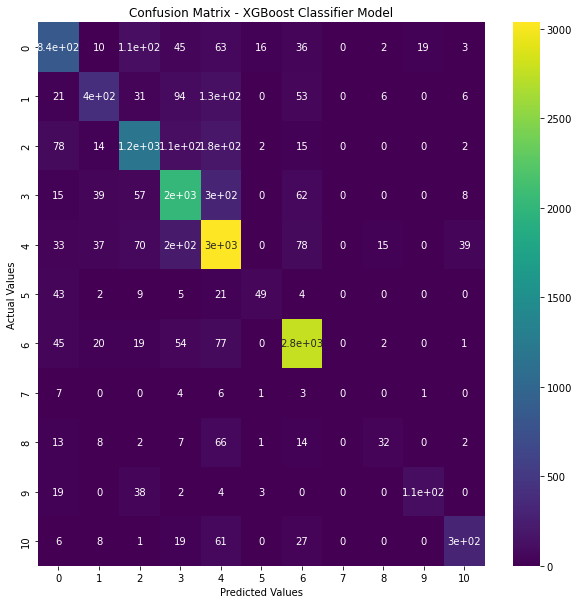

In [53]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_xgb, annot=True, cmap='viridis') #, ax=ax) #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - XGBoost Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### XGBoost Classifier performed slightly worse than Passive Aggressive and Logistic Regression Classifiers but marginally better than Random Forest Classifier.
- ### No evidence of overfitting with similar metrics between training and test data.

## LightGBM Classifier

In [56]:
# Optimize LightGBM Classifier Classifier with optuna
def lgb_objective(trial):
    #boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss", "rf"])
    num_leaves = trial.suggest_int("num_leaves", 4, 20, step=4, log=False) #decrease
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2, log=False) #decrease
    learning_rate = trial.suggest_float("learning_rate", 0.06, 1.2, step=0.02, log=False)
    n_estimators = trial.suggest_int("n_estimators", 350, 500, step=25, log=False) #increase
    min_child_weight = trial.suggest_float("min_child_weight", 0.01, 0.10, step=0.01, log=False) #increase
    min_child_samples = trial.suggest_int("min_child_samples", 200, 300, step=25, log=False) #decrease
    subsample = trial.suggest_float("subsample", 0.2, 1.0, step=0.2, log=False)
            
    ## Create Model
    lgb = LGBMClassifier(boosting_type="gbdt", num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, 
                            n_estimators=n_estimators, min_child_weight=min_child_weight, min_child_samples=min_child_samples, 
                            subsample=subsample, objective="multiclass", random_state = 2022) #class_weight=class_weights_dict, 

    ## Fit Model
    lgb.fit(X_train, y_train)

    return accuracy_score(y_test, lgb.predict(X_test))

In [57]:
lgb_study = optuna.create_study(study_name="LightGBM Classifier", direction="maximize")
lgb_study.optimize(lgb_objective, n_trials=10)

[I 2022-11-28 14:11:36,682] A new study created in memory with name: LightGBM Classifier
[I 2022-11-28 14:13:39,380] Trial 0 finished with value: 0.22923215087561744 and parameters: {'num_leaves': 8, 'max_depth': 2, 'learning_rate': 0.6399999999999999, 'n_estimators': 375, 'min_child_weight': 0.03, 'min_child_samples': 300, 'subsample': 0.4}. Best is trial 0 with value: 0.22923215087561744.
[I 2022-11-28 14:16:39,912] Trial 1 finished with value: 0.181335129471636 and parameters: {'num_leaves': 4, 'max_depth': 2, 'learning_rate': 0.6000000000000001, 'n_estimators': 475, 'min_child_weight': 0.06999999999999999, 'min_child_samples': 200, 'subsample': 0.6000000000000001}. Best is trial 0 with value: 0.22923215087561744.
[I 2022-11-28 14:19:06,437] Trial 2 finished with value: 0.27039365364466394 and parameters: {'num_leaves': 8, 'max_depth': 8, 'learning_rate': 0.8999999999999999, 'n_estimators': 400, 'min_child_weight': 0.060000000000000005, 'min_child_samples': 225, 'subsample': 1.0}. B

In [58]:
print("Best Params: {}".format(lgb_study.best_params))
print("\nBest Accuracy: {}".format(lgb_study.best_value))

Best Params: {'num_leaves': 12, 'max_depth': 2, 'learning_rate': 0.3, 'n_estimators': 450, 'min_child_weight': 0.02, 'min_child_samples': 250, 'subsample': 0.2}

Best Accuracy: 0.8405927256398743


In [59]:
lgb_clf = LGBMClassifier(**lgb_study.best_params)
lgb_clf.fit(X_train, y_train)

y_pred_train = lgb_clf.predict(X_train)
y_pred_test = lgb_clf.predict(X_test)

lgb_train_acc = accuracy_score(y_train, y_pred_train)
lgb_test_acc = accuracy_score(y_test, y_pred_test)

lgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
lgb_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("LightGBM Classifier Accuracy on Train Dataset: {}".format(lgb_train_acc))
print("\nLightGBM Classifier Accuracy on Test Dataset: {}".format(lgb_test_acc))
print("#####################")
print("\nLightGBM Classifier F1 Score on Train Dataset: {}".format(lgb_train_f1))
print("\nLightGBM Classifier F1 Score on Test Dataset: {}".format(lgb_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_lgb = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_lgb = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_lgb

LightGBM Classifier Accuracy on Train Dataset: 0.9167165631315022

LightGBM Classifier Accuracy on Test Dataset: 0.8405927256398743
#####################

LightGBM Classifier F1 Score on Train Dataset: 0.9163601491668051

LightGBM Classifier F1 Score on Test Dataset: 0.8380584629776278


,precision,recall,f1-score,support
0,0.776732,0.795096,0.785807,1142.000000
1,0.707692,0.625000,0.663781,736.000000
2,0.795226,0.798235,0.796728,1586.000000
3,0.854084,0.859880,0.856972,2505.000000
4,0.830032,0.883224,0.855802,3511.000000
5,0.728261,0.503759,0.595556,133.000000
6,0.936220,0.934651,0.935435,2984.000000
7,0.000000,0.000000,0.000000,22.000000
8,0.546392,0.365517,0.438017,145.000000
9,0.740741,0.697674,0.718563,172.000000


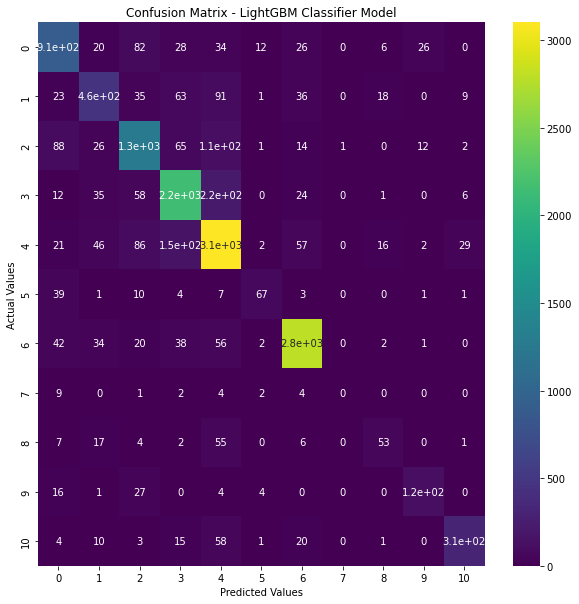

In [60]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lgb, annot=True, cmap='viridis') #, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - LightGBM Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### LightGBM Classifier performed about the same as the Passive Aggressive and Logistic Regression Classifiers and, therefore, better than the Random Forest and XGBoost Classifiers.
- ### Marginal evidence of overfitting with higher metrics on training data.

## Save Models

In [62]:
pickle.dump(log_clf, open('./bin/tfidf/log_clf.pkl', 'wb'))
pickle.dump(pac_clf, open('./bin/tfidf/pac_clf.pkl', 'wb'))
pickle.dump(rfc_clf, open('./bin/tfidf/rfc_clf.pkl', 'wb'))
pickle.dump(xgb_clf, open('./bin/tfidf/xgb_clf.pkl', 'wb'))
pickle.dump(lgb_clf, open('./bin/tfidf/lgb_clf.pkl', 'wb'))

## Ensemble best models together to balance bias-variance tradeoff / mitigate any overfitting.

In [ ]:
# load 3 best saved models
log_clf = pickle.load(open('./bin/tfidf/log_clf.pkl', 'rb'))
pac_clf = pickle.load(open('./bin/tfidf/pac_clf.pkl', 'rb'))
lgb_clf = pickle.load(open('./bin/tfidf/lgb_clf.pkl', 'rb'))

In [70]:
ensemble_clf = VotingClassifier(estimators=[('log', log_clf), ('pac', pac_clf), ('lgb', lgb_clf)], 
                                    voting='hard') # must use 'hard' voting and not 'soft' argmax voting since pac does not have predict_proba

In [71]:
ensemble_clf = ensemble_clf.fit(X_train, y_train)

In [72]:
y_pred_train_ensemble = ensemble_clf.predict(X_train)
y_pred_test_ensemble = ensemble_clf.predict(X_test)

In [73]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_test_acc = accuracy_score(y_test, y_pred_test_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_test_f1 = f1_score(y_test, y_pred_test_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Test Dataset: {}".format(results_ensemble_test_acc))
print("#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Test Dataset: {}".format(results_ensemble_test_f1))

Ensemble Accuracy on Train Dataset: 0.9090449816630491

Ensemble Accuracy on Test Dataset: 0.8506211644963328
#####################

Ensemble F1 Score on Train Dataset: 0.9082211318733782

Ensemble F1 Score on Test Dataset: 0.8471514707211656


- ### Still some overfitting to training data.  Try removing pac and only ensembling Logistic Regression and LightGBM together using 'soft' argmax voting with predict_proba

In [74]:
ensemble_clf_soft = VotingClassifier(estimators=[('log', log_clf), ('lgb', lgb_clf)], 
                                    voting='soft')

In [75]:
ensemble_clf_soft = ensemble_clf_soft.fit(X_train, y_train)

In [76]:
y_pred_train_ensemble = ensemble_clf_soft.predict(X_train)
y_pred_test_ensemble = ensemble_clf_soft.predict(X_test)

In [77]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_test_acc = accuracy_score(y_test, y_pred_test_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_test_f1 = f1_score(y_test, y_pred_test_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Test Dataset: {}".format(results_ensemble_test_acc))
print("#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Test Dataset: {}".format(results_ensemble_test_f1))

Ensemble Accuracy on Train Dataset: 0.9106915650026196

Ensemble Accuracy on Test Dataset: 0.8515940727436012
#####################

Ensemble F1 Score on Train Dataset: 0.9100973527599954

Ensemble F1 Score on Test Dataset: 0.8483338785672996


- ### Still some overfitting to training data but not drastic. Accuracy and f1 scores are slightly better when just ensembling Logistic Regression and LightGBM Classifiers using 'soft' argmax voting (predict_proba) than ensembling Logistic Regression, Passive Aggressive, and LightGBM Classifiers using 'hard' voting (predict, not predict_proba). 

## Look to improve results with feature engineering on the text

#### Extract text related features
1. Character count
2. Word count
3. Word density
4. Punctutation count
5. Title Word count
6. Uppercase word count
7. Stopword count

In [78]:
df.head()

,text,label,target
190126,XXXX has claimed I owe them for XXXX years de...,Debt collection,4
190135,Due to inconsistencies in the amount owed that...,Consumer Loan,1
190155,In XXXXXXXX my wages that I earned at my job d...,Mortgage,6
190207,I have an open and current mortgage with Chase...,Mortgage,6
190208,XXXX was submitted XXXXXXXX At the time I subm...,Mortgage,6


In [79]:
# extract some features from text
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))
df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
df['stopword_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

In [80]:
df.head()

,text,label,target,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count
190126,XXXX has claimed I owe them for XXXX years de...,Debt collection,4,279,52,5.264151,0,7,10,26
190135,Due to inconsistencies in the amount owed that...,Consumer Loan,1,1251,238,5.234310,0,27,23,126
190155,In XXXXXXXX my wages that I earned at my job d...,Mortgage,6,3464,658,5.256449,6,71,52,355
190207,I have an open and current mortgage with Chase...,Mortgage,6,430,74,5.733333,0,11,11,32
190208,XXXX was submitted XXXXXXXX At the time I subm...,Mortgage,6,1503,259,5.780769,0,19,14,141


#### Sentiment Analysis
1. Polarity
2. Subjectivity

In [83]:
df['text_polarity'] = df['text'].apply(lambda x: TextBlob(x).polarity)
df['text_subjectivity'] = df['text'].apply(lambda x: TextBlob(x).subjectivity)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   text                   66806 non-null  object 
 1   label                  66806 non-null  object 
 2   target                 66806 non-null  int8   
 3   char_count             66806 non-null  int64  
 4   word_count             66806 non-null  int64  
 5   word_density           66806 non-null  float64
 6   punctuation_count      66806 non-null  int64  
 7   title_word_count       66806 non-null  int64  
 8   upper_case_word_count  66806 non-null  int64  
 9   stopword_count         66806 non-null  int64  
 10  text_polarity          66806 non-null  float64
 11  text_subjectivity      66806 non-null  float64
dtypes: float64(3), int64(6), int8(1), object(2)
memory usage: 6.2+ MB


In [85]:
numFeatures=['char_count', 'word_count', 'word_density', 'punctuation_count', 'title_word_count', 
            'upper_case_word_count', 'stopword_count', 'text_polarity', 'text_subjectivity']

In [86]:
df[numFeatures].head(3)

,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count,text_polarity,text_subjectivity
190126,279,52,5.264151,0,7,10,26,0.000000,0.000000
190135,1251,238,5.234310,0,27,23,126,0.085000,0.467500
190155,3464,658,5.256449,6,71,52,355,-0.016155,0.455409


In [87]:
df[numFeatures].dtypes

char_count                 int64
word_count                 int64
word_density             float64
punctuation_count          int64
title_word_count           int64
upper_case_word_count      int64
stopword_count             int64
text_polarity            float64
text_subjectivity        float64
dtype: object

In [88]:
# Load X matrix here:
X_text = sparse.load_npz("./bin/tfidf/X_text.npz")

In [90]:
X = hstack((X_text, StandardScaler().fit_transform(df[numFeatures]))).tocsr()

## Save feature engineered X matrix and df

In [91]:
#Save the feature engineered X matrix into an NPZ file
sparse.save_npz("./bin/tfidf/X_featured_engineered.npz", X)

In [92]:
#Save the feature engineered dataframe
pickle.dump(df, open("./bin/tfidf/df_feature_engineered.pkl",'wb'))

In [ ]:
# Load feature engineered X matrix and df:
X = sparse.load_npz("./bin/tfidf/X_featured_engineered.npz")
df = pickle.load(open("./bin/tfidf/df_feature_engineered.pkl", 'rb'))

In [93]:
print(X)

  (0, 172)	0.11841887712565843
  (0, 179)	0.13975713778412782
  (0, 202)	0.1405638338092625
  (0, 203)	0.22365830584947977
  (0, 569)	0.11730573254807165
  (0, 714)	0.15422477070313387
  (0, 717)	0.2606784861169404
  (0, 826)	0.10935226522853173
  (0, 859)	0.12486571738159466
  (0, 860)	0.22115749727707837
  (0, 891)	0.09891690865826656
  (0, 894)	0.14766461202505765
  (0, 1024)	0.11590478672554481
  (0, 1309)	0.17662824810887562
  (0, 1753)	0.21647967772925253
  (0, 1754)	0.26636888787163054
  (0, 1903)	0.15482017344254168
  (0, 2110)	0.20079812332469088
  (0, 2148)	0.22912396180812358
  (0, 2865)	0.11452403769201529
  (0, 2871)	0.1853503057215472
  (0, 2879)	0.09908123962976813
  (0, 2951)	0.08257497398319331
  (0, 3006)	0.23642049527306408
  (0, 3183)	0.14223767778094765
  :	:
  (66805, 4451)	0.04627605789149749
  (66805, 4473)	0.06615802823578464
  (66805, 4484)	0.055693632865173516
  (66805, 4516)	0.0313790459348524
  (66805, 4518)	0.09224444921364815
  (66805, 4540)	0.06054202375

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   text                   66806 non-null  object 
 1   label                  66806 non-null  object 
 2   target                 66806 non-null  int8   
 3   char_count             66806 non-null  int64  
 4   word_count             66806 non-null  int64  
 5   word_density           66806 non-null  float64
 6   punctuation_count      66806 non-null  int64  
 7   title_word_count       66806 non-null  int64  
 8   upper_case_word_count  66806 non-null  int64  
 9   stopword_count         66806 non-null  int64  
 10  text_polarity          66806 non-null  float64
 11  text_subjectivity      66806 non-null  float64
dtypes: float64(3), int64(6), int8(1), object(2)
memory usage: 6.2+ MB


In [95]:
y = df['target'].values
print(X.shape)
print(y.shape)

(66806, 5009)
(66806,)


## Split feature engineered data into training and test datasets.

In [96]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [21552 17614 26675 ... 21287 55579 26041] TEST: [38106 56208   152 ... 62311   397 32064]
TRAIN: [31334 33221 32682 ... 43019 57821  1023] TEST: [45340 25255 49937 ...  9552 47021 23457]


## Fit ensemble model with 'soft' voting onto feature engineered data.

In [97]:
ensemble_clf_soft_fe = VotingClassifier(estimators=[('log', log_clf), ('lgb', lgb_clf)], 
                                        voting='soft')

In [98]:
ensemble_clf_soft_fe = ensemble_clf_soft_fe.fit(X_train, y_train)

In [99]:
y_pred_train_ensemble = ensemble_clf_soft_fe.predict(X_train)
y_pred_test_ensemble = ensemble_clf_soft_fe.predict(X_test)

In [100]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_test_acc = accuracy_score(y_test, y_pred_test_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_test_f1 = f1_score(y_test, y_pred_test_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Test Dataset: {}".format(results_ensemble_test_acc))
print("#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Test Dataset: {}".format(results_ensemble_test_f1))

Ensemble Accuracy on Train Dataset: 0.9123194371678767

Ensemble Accuracy on Test Dataset: 0.8515940727436012
#####################

Ensemble F1 Score on Train Dataset: 0.9117656057711891

Ensemble F1 Score on Test Dataset: 0.8484187601950788


- ### Still some overfitting to training data but not drastic. However, not much improvement with text-related engineered features.
- ### Try word embeddings using Gensim Word2Vec and Doc2Vec next.